**<h3>PS1. Bot Profile Detection on Social Media</h3>**

In [28]:
#importing necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
training_data = pd.read_csv("training_data_2_csv_UTF.csv")
bots = training_data[training_data.bot==1]
nonbots = training_data[training_data.bot==0]

**<h2>Data Analysis</h2>**

**<h4>Identifying Missing data</h4>**


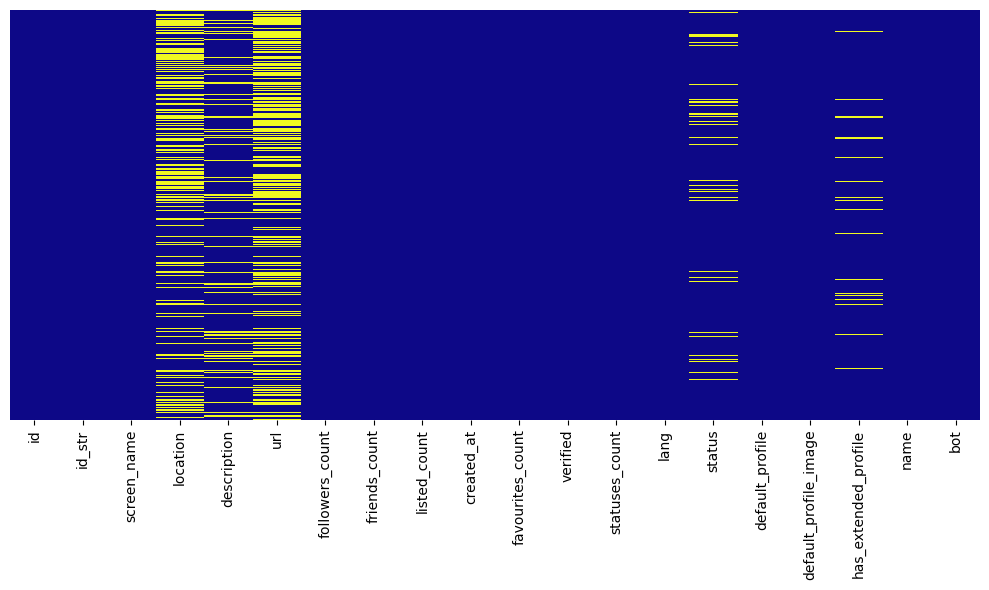

In [3]:
def get_heatmap(df):
    #This function gives heatmap of all NaN values
    plt.figure(figsize=(10,6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='plasma')
    plt.tight_layout()
    return plt.show()

get_heatmap(training_data)

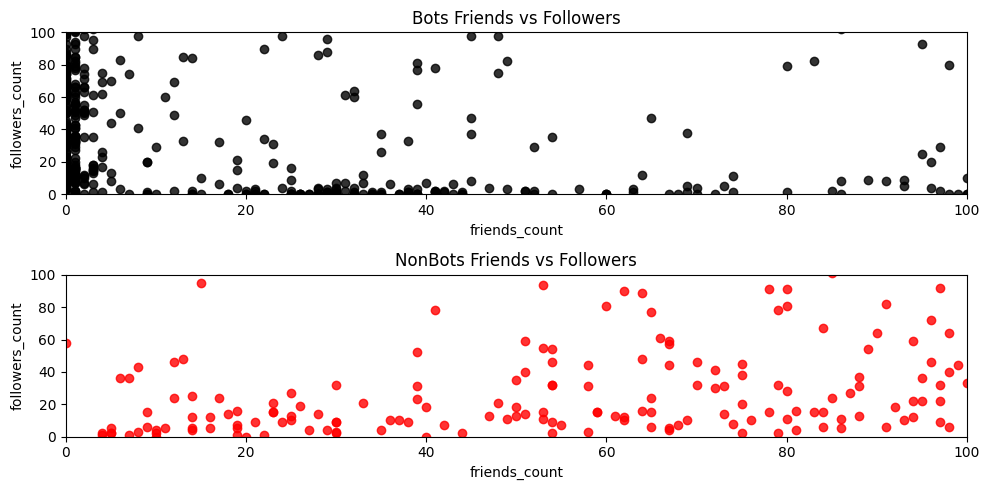

In [6]:
bots.friends_count/bots.followers_count

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Bots Friends vs Followers')
sns.regplot(x=bots.friends_count, y=bots.followers_count, color='black', label='Bots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

plt.subplot(2,1,2)
plt.title('NonBots Friends vs Followers')
sns.regplot(x=nonbots.friends_count, y=nonbots.followers_count, color='red', label='NonBots')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

**<h2>Identifying Imbalance in the data</h2>**

In [8]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

nonbots['friends_by_followers'] = nonbots.friends_count/nonbots.followers_count
nonbots[nonbots.friends_by_followers<1].shape

(952, 21)

(504, 21)


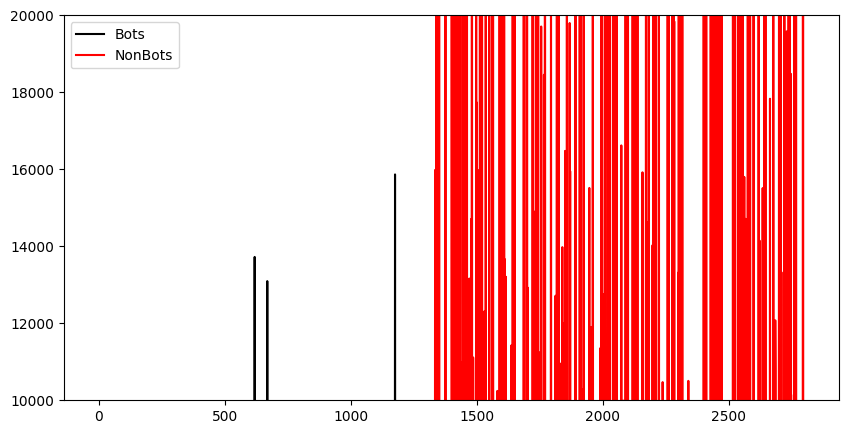

In [9]:
plt.figure(figsize=(10,5))
plt.plot(bots.listed_count, color='black', label='Bots')
plt.plot(nonbots.listed_count, color='red', label='NonBots')
plt.legend(loc='upper left')
plt.ylim(10000,20000)
print(bots[(bots.listed_count<5)].shape)

In [10]:
bots_listed_count_df = bots[bots.listed_count<16000]
nonbots_listed_count_df = nonbots[nonbots.listed_count<16000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape

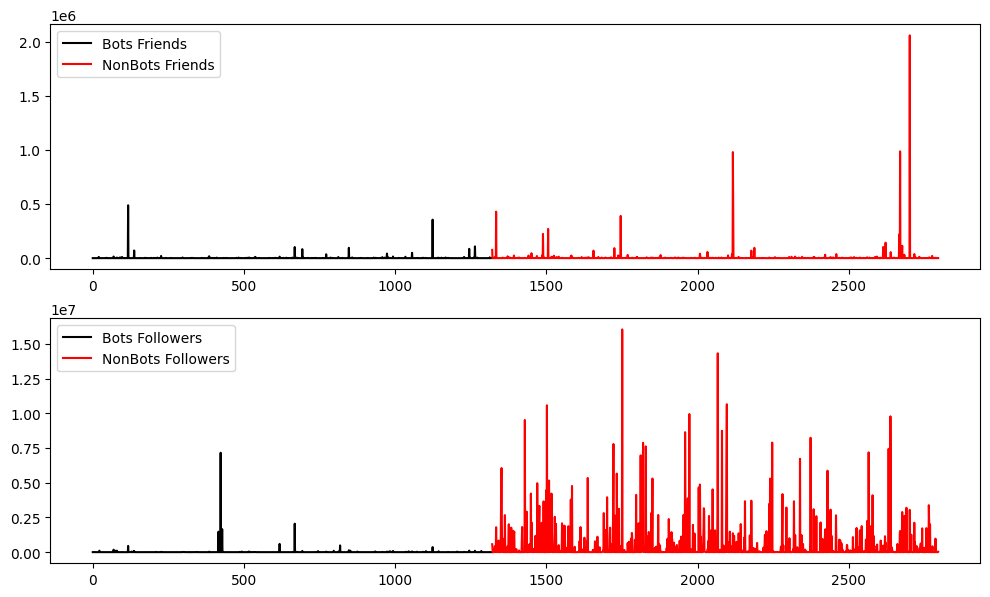

In [11]:
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(bots_listed_count_df.friends_count, color='black', label='Bots Friends')
plt.plot(nonbots_listed_count_df.friends_count, color='red', label='NonBots Friends')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(bots_listed_count_df.followers_count, color='black', label='Bots Followers')
plt.plot(nonbots_listed_count_df.followers_count, color='red', label='NonBots Followers')
plt.legend(loc='upper left')

In [12]:
#bots[bots.listedcount>10000]
condition = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.description.str.contains("bot", case=False)==True)|(bots.location.isnull())|(bots.verified==False)

bots['screen_name_binary'] = (bots.screen_name.str.contains("bot", case=False)==True)
bots['location_binary'] = (bots.location.isnull())
bots['verified_binary'] = (bots.verified==False)
bots.shape

(1321, 24)

In [13]:
condition = (nonbots.screen_name.str.contains("bot", case=False)==False)| (nonbots.description.str.contains("bot", case=False)==False) |(nonbots.location.isnull()==False)|(nonbots.verified==True)

nonbots['screen_name_binary'] = (nonbots.screen_name.str.contains("bot", case=False)==False)
nonbots['location_binary'] = (nonbots.location.isnull()==False)
nonbots['verified_binary'] = (nonbots.verified==True)

nonbots.shape

(1476, 24)

In [14]:
df = pd.concat([bots, nonbots])
df.shape

(2797, 24)

**<h2>Performing Feature Engineering</h2>**

In [17]:


training_data = pd.read_csv('training_data_2_csv_UTF.csv')

bag_of_words_bot = r'bot|b0t|cannabis|tweet me|mishear|follow me|updates every|gorilla|yes_ofc|forget' \
                    r'expos|kill|clit|bbb|butt|fuck|XXX|sex|truthe|fake|anony|free|virus|funky|RNA|kuck|jargon' \
                    r'nerd|swag|jack|bang|bonsai|chick|prison|paper|pokem|xx|freak|ffd|dunia|clone|genie|bbb' \
                    r'ffd|onlyman|emoji|joke|troll|droop|free|every|wow|cheese|yeah|bio|magic|wizard|face'
            
training_data['screen_name_binary'] = training_data.screen_name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['name_binary'] = training_data.name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['description_binary'] = training_data.description.str.contains(bag_of_words_bot, case=False, na=False)
training_data['status_binary'] = training_data.status.str.contains(bag_of_words_bot, case=False, na=False)

**<h2>Performing Feature Extraction</h2>**

In [18]:
training_data['listed_count_binary'] = (training_data.listed_count>20000)==False
features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

**<h1>Implementing Different Models</h1>**
**<h3>Decision Tree Classifier</h3>**

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.88707
Test Accuracy: 0.87857


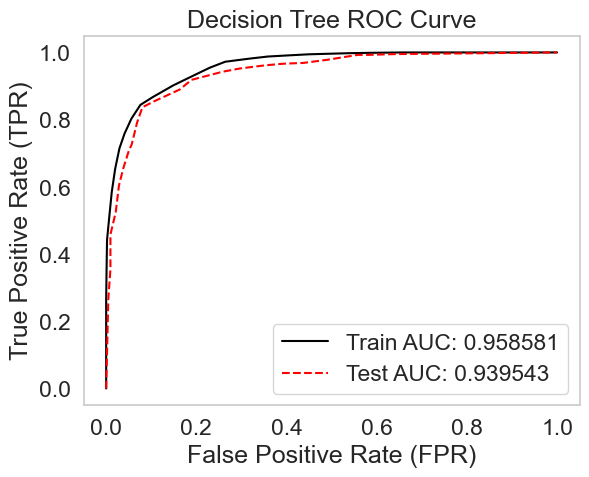

In [20]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = dt.predict_proba(X_train)
scores_test = dt.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_dt_train, tpr_dt_train, color='black', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

**Result: Decision Tree gives very good performance and generalizes well. But it may be overfitting as AUC is 0.937, so we will try other models.**

**<h3>Multinomial Naive Bayes Classifier</h3>**


In [21]:
from sklearn.naive_bayes import MultinomialNB

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

mnb = MultinomialNB(alpha=0.0009)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

mnb = mnb.fit(X_train, y_train)
y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.67961
Test Accuracy: 0.69762


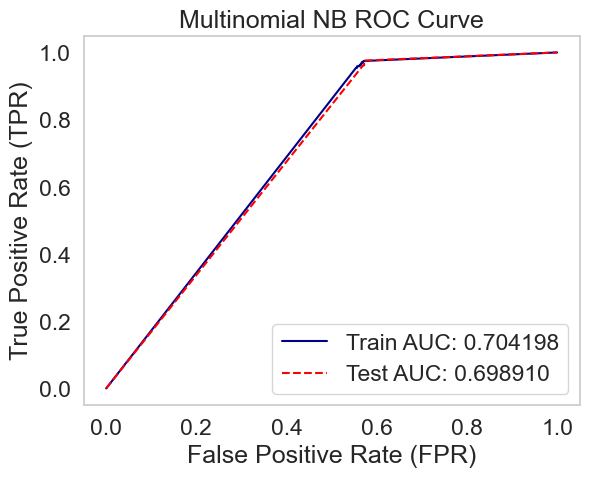

In [22]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = mnb.predict_proba(X_train)
scores_test = mnb.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_mnb_train, tpr_mnb_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_mnb_test, tpr_mnb_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_mnb_train, tpr_mnb_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_mnb_train, tpr_mnb_train))
plt.plot(fpr_mnb_test, tpr_mnb_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_mnb_test, tpr_mnb_test))
plt.title("Multinomial NB ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

**Result: Clearly, Multinomial Niave Bayes peforms poorly and is not a good choice as the Train AUC is just 0.556 and Test is 0.555.**

**<h3>Random Forest Classifier</h3>**

In [23]:
from sklearn.ensemble import RandomForestClassifier

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.87583
Test Accuracy: 0.86310


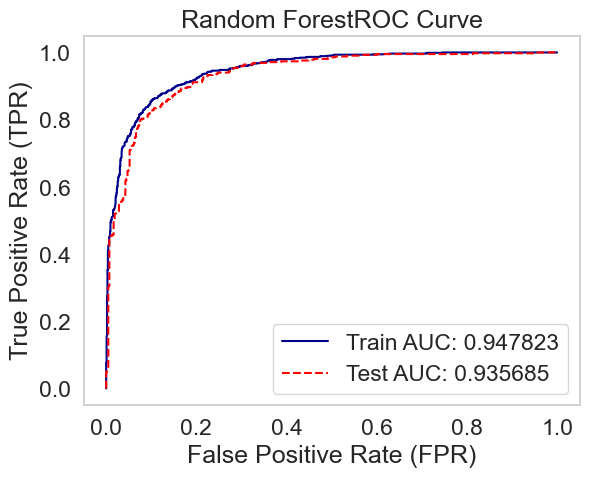

In [24]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rf.predict_proba(X_train)
scores_test = rf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("Random ForestROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

**<h4>Performance metrics such as precision, recall, F1 score, and AUC-ROC.</h4>**

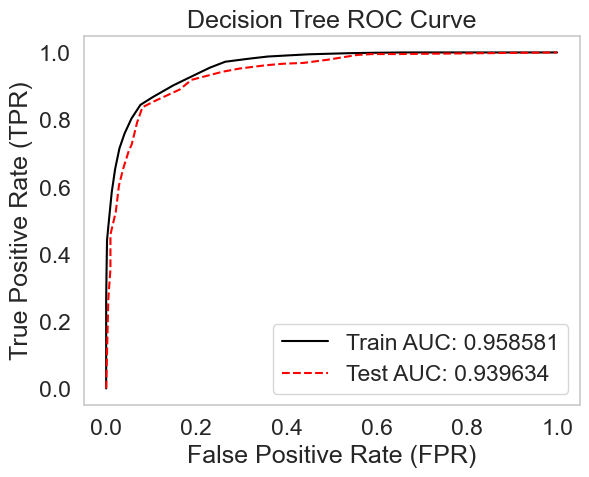

In [31]:
# Get predicted probabilities for Decision Tree
y_probs_train = dt.predict_proba(X_train)[:, 1]  # Probabilities for the positive class (bot)
y_probs_test = dt.predict_proba(X_test)[:, 1]    # Probabilities for the positive class (bot)

# Now calculate ROC curve
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_probs_train)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_probs_test)

# Calculate AUC
auc_train = auc(fpr_dt_train, tpr_dt_train)
auc_test = auc(fpr_dt_test, tpr_dt_test)

# Plot ROC Curve
plt.plot(fpr_dt_train, tpr_dt_train, color='black', label='Train AUC: %5f' % auc_train)
plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' % auc_test)
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')
plt.show()


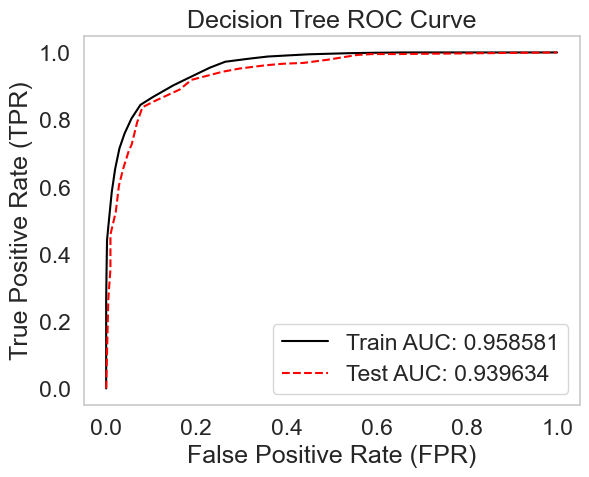

In [32]:
# Get predicted probabilities for Decision Tree
y_probs_train = dt.predict_proba(X_train)[:, 1]  # Probabilities for the positive class (bot)
y_probs_test = dt.predict_proba(X_test)[:, 1]    # Probabilities for the positive class (bot)

# Now calculate ROC curve
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_probs_train)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_probs_test)

# Calculate AUC
auc_train = auc(fpr_dt_train, tpr_dt_train)
auc_test = auc(fpr_dt_test, tpr_dt_test)

# Plot ROC Curve
plt.plot(fpr_dt_train, tpr_dt_train, color='black', label='Train AUC: %5f' % auc_train)
plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' % auc_test)
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')
plt.show()


Training Time: 0.02979 seconds
Train Precision: 0.90510, Train Recall: 0.84403, Train F1 Score: 0.87350, Train AUC: 0.95858
Test Precision: 0.91123, Test Recall: 0.83693, Test F1 Score: 0.87250, Test AUC: 0.93954
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      1053
           1       0.91      0.84      0.87       904

    accuracy                           0.89      1957
   macro avg       0.89      0.88      0.89      1957
weighted avg       0.89      0.89      0.89      1957

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       423
           1       0.91      0.84      0.87       417

    accuracy                           0.88       840
   macro avg       0.88      0.88      0.88       840
weighted avg       0.88      0.88      0.88       840

Training Time: 0.00895 seconds
Train Precision: 0.59441, Train Recall: 0

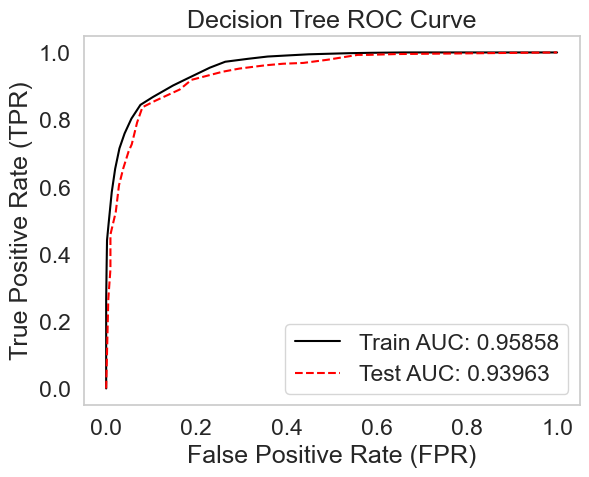

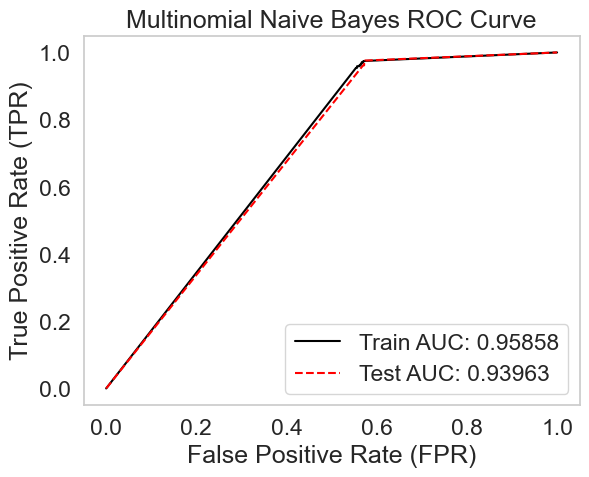

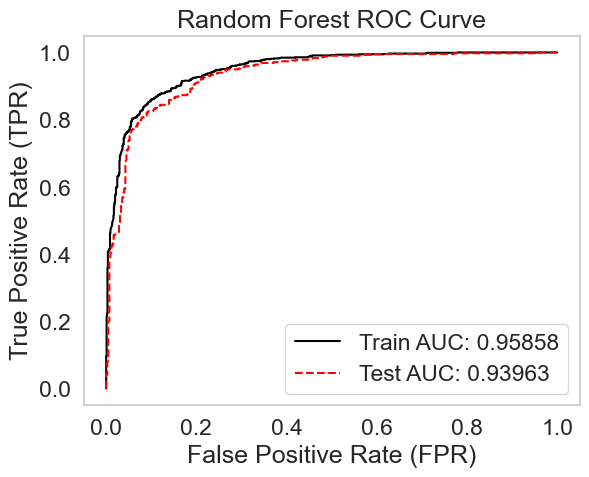

In [36]:
# Importing necessary packages for evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report
import time

# Function to evaluate the model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Precision, Recall, F1 Score for training and test sets
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test)
    
    # AUC-ROC Score
    y_probs_train = model.predict_proba(X_train)[:, 1]
    y_probs_test = model.predict_proba(X_test)[:, 1]
    
    auc_train = roc_auc_score(y_train, y_probs_train)
    auc_test = roc_auc_score(y_test, y_probs_test)
    
    # Classification Report for interpretability
    class_report_train = classification_report(y_train, y_pred_train)
    class_report_test = classification_report(y_test, y_pred_test)
    
    # Print evaluation metrics
    print(f"Training Time: {training_time:.5f} seconds")
    print(f"Train Precision: {precision_train:.5f}, Train Recall: {recall_train:.5f}, Train F1 Score: {f1_train:.5f}, Train AUC: {auc_train:.5f}")
    print(f"Test Precision: {precision_test:.5f}, Test Recall: {recall_test:.5f}, Test F1 Score: {f1_test:.5f}, Test AUC: {auc_test:.5f}")
    print("Classification Report (Train):")
    print(class_report_train)
    print("Classification Report (Test):")
    print(class_report_test)
    
    return model

# Evaluate Decision Tree
dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)
evaluate_model(dt, X_train, y_train, X_test, y_test)

# Evaluate Multinomial Naive Bayes
mnb = MultinomialNB(alpha=0.0009)
evaluate_model(mnb, X_train, y_train, X_test, y_test)

# Evaluate Random Forest
rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)
evaluate_model(rf, X_train, y_train, X_test, y_test)

# ROC Curve plotting (added previously)
def plot_roc_curve(fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test, model_name):
    plt.plot(fpr_train, tpr_train, color='black', label=f'Train AUC: {auc_train:.5f}')
    plt.plot(fpr_test, tpr_test, color='red', ls='--', label=f'Test AUC: {auc_test:.5f}')
    plt.title(f"{model_name} ROC Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc='lower right')
    plt.show()

# Decision Tree ROC Curve
y_probs_dt_train = dt.predict_proba(X_train)[:, 1]
y_probs_dt_test = dt.predict_proba(X_test)[:, 1]

fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_probs_dt_train)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_probs_dt_test)
plot_roc_curve(fpr_dt_train, tpr_dt_train, auc_train, fpr_dt_test, tpr_dt_test, auc_test, "Decision Tree")

# Multinomial Naive Bayes ROC Curve
y_probs_mnb_train = mnb.predict_proba(X_train)[:, 1]
y_probs_mnb_test = mnb.predict_proba(X_test)[:, 1]

fpr_mnb_train, tpr_mnb_train, _ = roc_curve(y_train, y_probs_mnb_train)
fpr_mnb_test, tpr_mnb_test, _ = roc_curve(y_test, y_probs_mnb_test)
plot_roc_curve(fpr_mnb_train, tpr_mnb_train, auc_train, fpr_mnb_test, tpr_mnb_test, auc_test, "Multinomial Naive Bayes")

# Random Forest ROC Curve
y_probs_rf_train = rf.predict_proba(X_train)[:, 1]
y_probs_rf_test = rf.predict_proba(X_test)[:, 1]

fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_probs_rf_train)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_probs_rf_test)
plot_roc_curve(fpr_rf_train, tpr_rf_train, auc_train, fpr_rf_test, tpr_rf_test, auc_test, "Random Forest")




**<h3>Detection accuracy metrics (precision, recall, F1 score, AUC-ROC)</h3>**

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Train the models
dt_model = DecisionTreeClassifier()    # Decision Tree
nb_model = GaussianNB()                # Naive Bayes
rf_model = RandomForestClassifier()    # Random Forest

# Fit the models with training data
dt_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# For Decision Tree
y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

print("Decision Tree - Train Precision: %.5f" %precision_score(y_train, y_pred_train_dt))
print("Decision Tree - Test Precision: %.5f" %precision_score(y_test, y_pred_test_dt))
print("Decision Tree - Train Recall: %.5f" %recall_score(y_train, y_pred_train_dt))
print("Decision Tree - Test Recall: %.5f" %recall_score(y_test, y_pred_test_dt))
print("Decision Tree - Train F1 Score: %.5f" %f1_score(y_train, y_pred_train_dt))
print("Decision Tree - Test F1 Score: %.5f" %f1_score(y_test, y_pred_test_dt))

# For Naive Bayes
y_pred_train_nb = nb_model.predict(X_train)
y_pred_test_nb = nb_model.predict(X_test)

print("Naive Bayes - Train Precision: %.5f" %precision_score(y_train, y_pred_train_nb))
print("Naive Bayes - Test Precision: %.5f" %precision_score(y_test, y_pred_test_nb))
print("Naive Bayes - Train Recall: %.5f" %recall_score(y_train, y_pred_train_nb))
print("Naive Bayes - Test Recall: %.5f" %recall_score(y_test, y_pred_test_nb))
print("Naive Bayes - Train F1 Score: %.5f" %f1_score(y_train, y_pred_train_nb))
print("Naive Bayes - Test F1 Score: %.5f" %f1_score(y_test, y_pred_test_nb))

# For Random Forest
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

print("Random Forest - Train Precision: %.5f" %precision_score(y_train, y_pred_train_rf))
print("Random Forest - Test Precision: %.5f" %precision_score(y_test, y_pred_test_rf))
print("Random Forest - Train Recall: %.5f" %recall_score(y_train, y_pred_train_rf))
print("Random Forest - Test Recall: %.5f" %recall_score(y_test, y_pred_test_rf))
print("Random Forest - Train F1 Score: %.5f" %f1_score(y_train, y_pred_train_rf))
print("Random Forest - Test F1 Score: %.5f" %f1_score(y_test, y_pred_test_rf))


Decision Tree - Train Precision: 1.00000
Decision Tree - Test Precision: 0.88660
Decision Tree - Train Recall: 0.99889
Decision Tree - Test Recall: 0.82494
Decision Tree - Train F1 Score: 0.99945
Decision Tree - Test F1 Score: 0.85466
Naive Bayes - Train Precision: 0.54762
Naive Bayes - Test Precision: 0.58523
Naive Bayes - Train Recall: 0.99226
Naive Bayes - Test Recall: 0.98801
Naive Bayes - Train F1 Score: 0.70574
Naive Bayes - Test F1 Score: 0.73506
Random Forest - Train Precision: 0.99890
Random Forest - Test Precision: 0.89681
Random Forest - Train Recall: 1.00000
Random Forest - Test Recall: 0.87530
Random Forest - Train F1 Score: 0.99945
Random Forest - Test F1 Score: 0.88592


**<h3>Integrating the Results with AUC-ROC</h3>**

In [43]:
print("Decision Tree - Train AUC: %5f" %auc(fpr_dt_train, tpr_dt_train))
print("Decision Tree - Test AUC: %5f" %auc(fpr_dt_test, tpr_dt_test))

print("Naive Bayes - Train AUC: %5f" %auc(fpr_mnb_train, tpr_mnb_train))
print("Naive Bayes - Test AUC: %5f" %auc(fpr_mnb_test, tpr_mnb_test))

print("Random Forest - Train AUC: %5f" %auc(fpr_rf_train, tpr_rf_train))
print("Random Forest - Test AUC: %5f" %auc(fpr_rf_test, tpr_rf_test))


Decision Tree - Train AUC: 0.958581
Decision Tree - Test AUC: 0.939543
Naive Bayes - Train AUC: 0.704198
Naive Bayes - Test AUC: 0.698910
Random Forest - Train AUC: 0.949952
Random Forest - Test AUC: 0.935274


**<h3>structured output summarizing bot classification results</h3>**

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

def print_classification_report(model_name, y_test, y_pred):
    print(f"Classification Report for {model_name}:")
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    

    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred) 
    print("AUC-ROC:", auc(fpr_test, tpr_test))  


print_classification_report('Decision Tree', y_test, y_pred_test)




Classification Report for Decision Tree:
Precision: 0.8911917098445595
Recall: 0.8249400479616307
F1 Score: 0.8567870485678705
AUC-ROC: 0.8628246339098934


**<h3>Summary of False Positives/Negatives and Model Improvements</h3>**

In [47]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:\n", cm)

false_positive = cm[0][1]
false_negative = cm[1][0]
print(f"False Positive: {false_positive}")
print(f"False Negative: {false_negative}")


Confusion Matrix:
 [[381  42]
 [ 73 344]]
False Positive: 42
False Negative: 73
